In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score,roc_auc_score,confusion_matrix, classification_report
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import optuna

In [2]:
training_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
output_data=pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

In [3]:
output_data.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [4]:
training_data.head()
training_data.shape

(891, 12)

In [5]:
test_data.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


<Axes: xlabel='Survived', ylabel='count'>

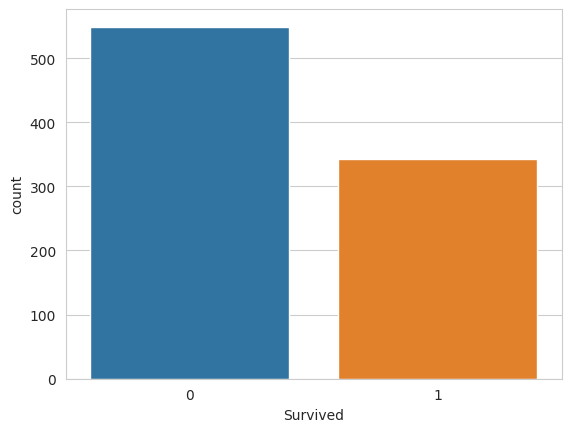

In [6]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=training_data)

In [7]:
filtered_data = training_data[~training_data['Embarked'].isin(['C', 'S', 'Q'])]
filtered_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


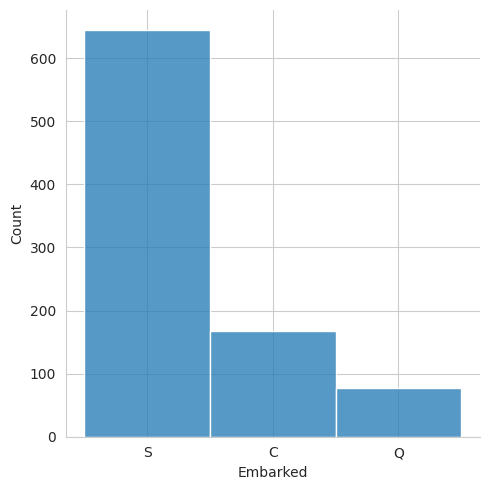

In [8]:
sns.displot(data=training_data,x='Embarked')

In [9]:
embarked_mode = training_data['Embarked'].mode()[0]
training_data['Embarked'].fillna(embarked_mode, inplace=True)

<Axes: xlabel='Survived', ylabel='count'>

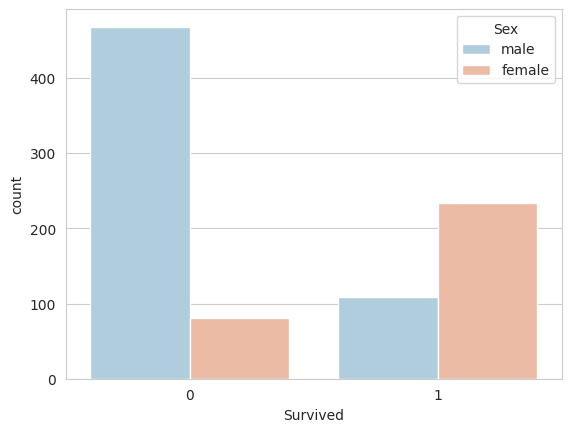

In [10]:
sns.countplot(x='Survived',data=training_data,hue='Sex',palette='RdBu_r')

<Axes: xlabel='Survived', ylabel='count'>

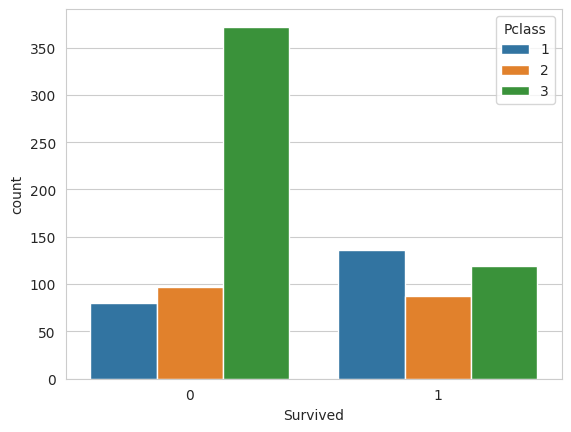

In [11]:
sns.countplot(x='Survived',data=training_data,hue='Pclass')

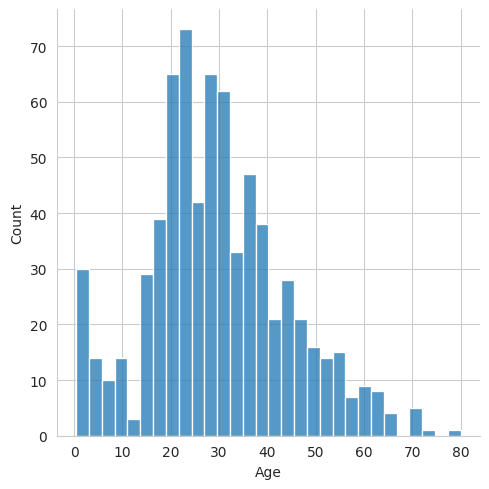

In [12]:
sns.displot(training_data['Age'],kde=False,bins=30)

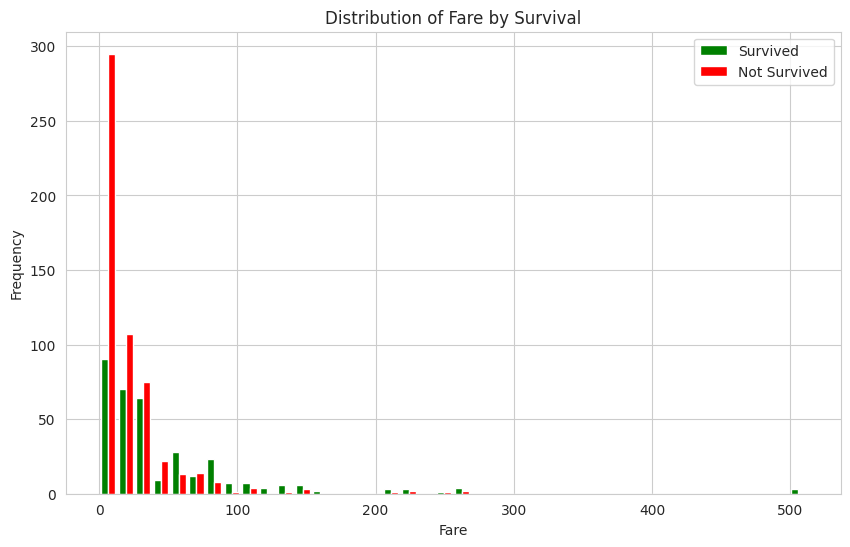

In [13]:
survived_fares = training_data[training_data['Survived'] == 1]['Fare']
not_survived_fares = training_data[training_data['Survived'] == 0]['Fare']

plt.figure(figsize=(10, 6))
plt.hist([survived_fares, not_survived_fares], bins=40, color=['green', 'red'], label=['Survived', 'Not Survived'])
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.title('Distribution of Fare by Survival')
plt.legend()
plt.show()

<Axes: xlabel='SibSp', ylabel='count'>

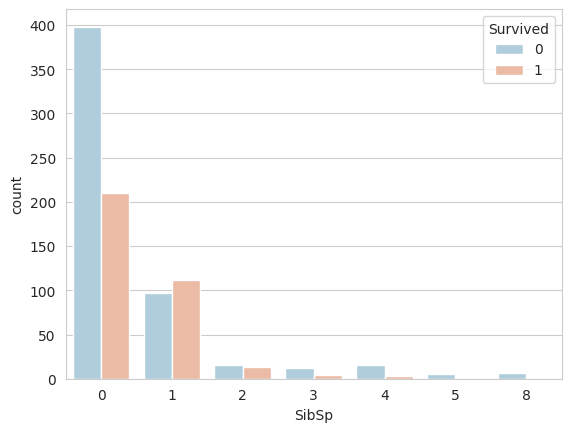

In [14]:
sns.countplot(x='SibSp',data=training_data,hue='Survived',palette='RdBu_r')

<Axes: xlabel='Parch', ylabel='count'>

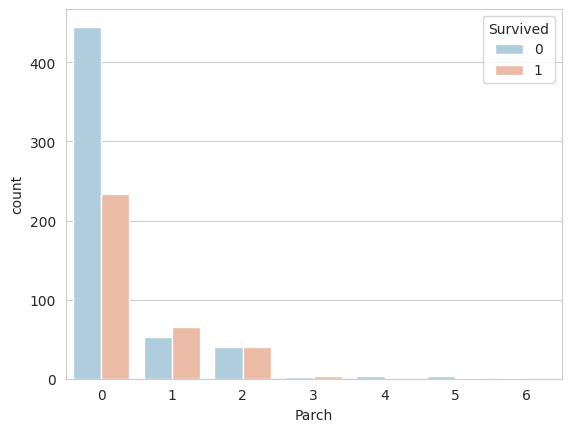

In [15]:
sns.countplot(x='Parch',data=training_data,hue='Survived',palette='RdBu_r')

<Axes: >

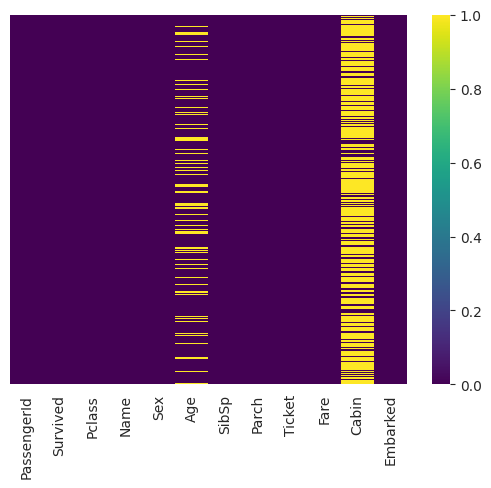

In [16]:
sns.heatmap(training_data.isnull(),yticklabels=False,cmap=('viridis'))

<Axes: >

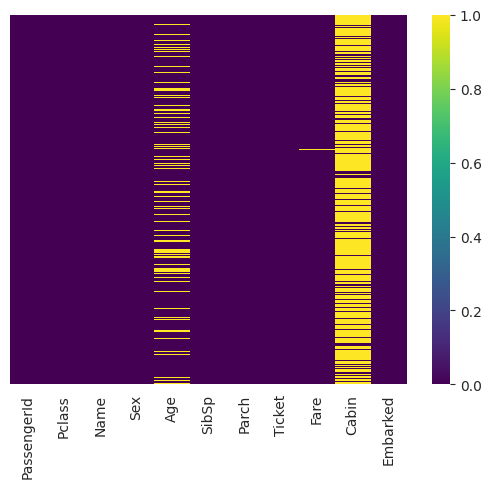

In [17]:
sns.heatmap(test_data.isnull(),yticklabels=False,cmap=('viridis'))

In [18]:
def add_title_and_encode(data):
    # Extract titles using a raw string for the regex pattern
    data['Title'] = data.Name.str.extract(r' ([A-Za-z]+)\.', expand=False)
    data.Title = data.Title.replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 
                                     'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    data.Title = data.Title.replace('Mlle', 'Miss')
    data.Title = data.Title.replace('Ms', 'Miss')
    data.Title = data.Title.replace('Mme', 'Mrs')
    
    # Apply OneHotEncoder to the 'Title' column
    encoder_title = OneHotEncoder(sparse_output=False, drop='first')
    title_encoded = encoder_title.fit_transform(data[['Title']])
    
    # Create a DataFrame with the encoded columns and appropriate column names
    title_encoded_df = pd.DataFrame(title_encoded, columns=encoder_title.get_feature_names_out(['Title'])).astype(int)
    
    # Concatenate the original data with the new one-hot-encoded columns
    data = pd.concat([data, title_encoded_df], axis=1)
    
    # Drop the original 'Title' column
    data.drop('Title', axis=1, inplace=True)
    
    # Apply OneHotEncoder to the 'Embarked' column
    encoder_embarked = OneHotEncoder(sparse_output=False, drop='first')
    embarked_encoded = encoder_embarked.fit_transform(data[['Embarked']])
    
    # Create a DataFrame with the encoded columns and appropriate column names
    embarked_encoded_df = pd.DataFrame(embarked_encoded, columns=encoder_embarked.get_feature_names_out(['Embarked'])).astype(int)
    
    # Concatenate the original data with the new one-hot-encoded columns
    data = pd.concat([data, embarked_encoded_df], axis=1)
    
    # Apply OneHotEncoder to the 'Sex' column
    encoder_Sex = OneHotEncoder(sparse_output=False, drop='first')
    Sex_encoded = encoder_Sex.fit_transform(data[['Sex']])
    
    # Create a DataFrame with the encoded columns and appropriate column names
    Sex_encoded_df = pd.DataFrame(Sex_encoded, columns=encoder_Sex.get_feature_names_out(['Sex'])).astype(int)
    
    # Concatenate the original data with the new one-hot-encoded columns
    data = pd.concat([data, Sex_encoded_df], axis=1)
    
    # Apply OneHotEncoder to the 'Pclass' column
    encoder_Pclass = OneHotEncoder(sparse_output=False, drop='first')
    Pclass_encoded = encoder_Pclass.fit_transform(data[['Pclass']])
    
    # Create a DataFrame with the encoded columns and appropriate column names
    Pclass_encoded_df = pd.DataFrame(Pclass_encoded, columns=encoder_Pclass.get_feature_names_out(['Pclass'])).astype(int)
    
    # Concatenate the original data with the new one-hot-encoded columns for Pclass
    data = pd.concat([data, Pclass_encoded_df], axis=1)
    
    # Drop the original 'Sex', 'Pclass', 'Embarked', and other unnecessary columns
    data.drop(['Sex', 'Pclass', 'Embarked', 'Name', 'PassengerId','Cabin','Ticket'], axis=1, inplace=True)
    
    return data

In [19]:
training_data=add_title_and_encode(training_data)
test_data=add_title_and_encode(test_data)

In [20]:
test_data.head()

,Age,SibSp,Parch,Fare,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Embarked_Q,Embarked_S,Sex_male,Pclass_2,Pclass_3
0,34.5,0,0,7.8292,0,1,0,0,1,0,1,0,1
1,47.0,1,0,7.0000,0,0,1,0,0,1,0,0,1
2,62.0,0,0,9.6875,0,1,0,0,1,0,1,1,0
3,27.0,0,0,8.6625,0,1,0,0,0,1,1,0,1
4,22.0,1,1,12.2875,0,0,1,0,0,1,0,0,1


In [21]:
training_data.head()

,Survived,Age,SibSp,Parch,Fare,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Embarked_Q,Embarked_S,Sex_male,Pclass_2,Pclass_3
0,0,22.0,1,0,7.2500,0,1,0,0,0,1,1,0,1
1,1,38.0,1,0,71.2833,0,0,1,0,0,0,0,0,0
2,1,26.0,0,0,7.9250,1,0,0,0,0,1,0,0,1
3,1,35.0,1,0,53.1000,0,0,1,0,0,1,0,0,0
4,0,35.0,0,0,8.0500,0,1,0,0,0,1,1,0,1


In [22]:
test_data['Fare'] = test_data['Fare'].fillna(np.mean(test_data['Fare']))
training_data['Fare'] = training_data['Fare'].fillna(np.mean(training_data['Fare']))

In [23]:
def fill_age_based_on_title(data):
    # Calculate median age for different encoded titles
    median_ages = data.groupby(['Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare'])['Age'].median()
    
    # Iterate over the dataset and fill missing Age values based on the calculated medians
    for index, row in data.iterrows():
        if pd.isnull(row['Age']):
            # Create a tuple of encoded title features
            encoded_titles = (row['Title_Miss'], row['Title_Mr'], row['Title_Mrs'], row['Title_Rare'])
            median_age = median_ages.loc[encoded_titles]
            data.at[index, 'Age'] = median_age
    
    return data

In [24]:
training_data=fill_age_based_on_title(training_data)
test_data=fill_age_based_on_title(test_data)

<Axes: >

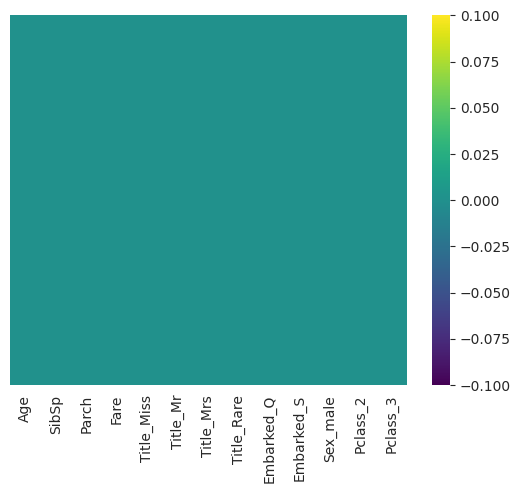

In [25]:
sns.heatmap(test_data.isnull(),yticklabels=False,cmap=('viridis'))

<Axes: >

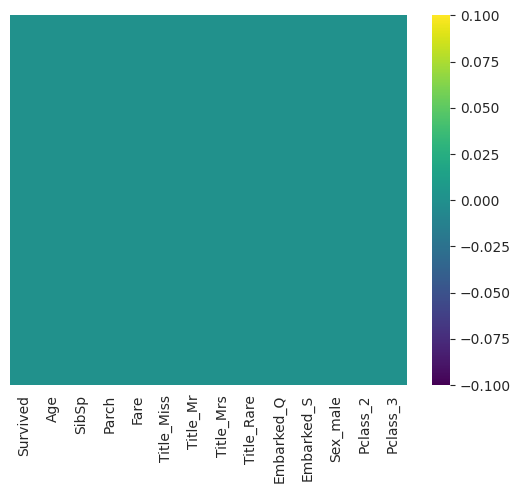

In [26]:
sns.heatmap(training_data.isnull(),yticklabels=False,cmap=('viridis'))

In [27]:
X = training_data.drop('Survived', axis=1)  # Features
y = training_data['Survived']  # Target

In [28]:
import os
import re
import warnings
print(os.listdir("../input"))
import io
import requests
import pandas as pd

url="https://github.com/thisisjasonjafari/my-datascientise-handcode/raw/master/005-datavisualization/titanic.csv"
s=requests.get(url).content
c=pd.read_csv(io.StringIO(s.decode('utf-8')))
 
test_data_with_labels = c
test_data_1 = pd.read_csv('../input/titanic/test.csv')

warnings.filterwarnings('ignore')

for i, name in enumerate(test_data_with_labels['name']):
    if '"' in name:
        test_data_with_labels['name'][i] = re.sub('"', '', name)
        
for i, name in enumerate(test_data_1['Name']):
    if '"' in name:
        test_data_1['Name'][i] = re.sub('"', '', name)
        
survived = []

for name in test_data_1['Name']:
    survived.append(int(test_data_with_labels.loc[test_data_with_labels['name'] == name]['survived'].values[-1]))

    
submission = pd.read_csv('../input/titanic/gender_submission.csv')
submission['Survived'] = survived
submission.to_csv('final1submission.csv', index=False)
pp=pd.read_csv('final1submission.csv')

['titanic', 'titanic-machine-learning-from-disaster']


ConnectionError: HTTPSConnectionPool(host='github.com', port=443): Max retries exceeded with url: /thisisjasonjafari/my-datascientise-handcode/raw/master/005-datavisualization/titanic.csv (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7a32a8133df0>: Failed to resolve 'github.com' ([Errno -3] Temporary failure in name resolution)"))

In [ ]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the model
model = SVC(kernel='linear')
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
# Comparing with actual Output
predictions = model.predict(test_data)
output = pd.DataFrame({'PassengerId': output_data['PassengerId'], 'Survived': predictions})

differences = output[output['Survived'] != pp['Survived']]
print(differences)

In [ ]:
predictions = final_model_RF.predict(test_data)

# Create and save the submission file
output = pd.DataFrame({'PassengerId': output_data['PassengerId'], 'Survived': predictions})
output.to_csv('Final_submission.csv', index=False)

xr = pd.read_csv('Final_submission.csv')

In [ ]:
xr.head()